In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

# Прогнозирование рейтингов эффективности баскетболистов

<img style="float: left; margin:2px;" src="https://docs.microsoft.com/en-us/learn/achievements/student-evangelism/predict-basketball-player-efficiency-ratings.svg">В этом модуле вы получите обзор статистики, связанной с баскетболистами (живыми и мультипликационными). Вы узнаете, как статистика формирует рейтинг эффективности игрока (PER) на текущую минуту.

Ваша цель — использовать методики машинного обучения для создания чистого набора данных игроков. Набор данных используется во время матчей для принятия быстрых решений и повышения шансов команды на победу.

## Загрузка данных о баскетболистах

In [2]:
player_df = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/SpaceJamANewLegacy/player_data.csv')
player_df.head()

,ID,points,possessions,team_pace,Unnamed: 4,Unnamed: 5,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
0,1,1893.0,1251.8,97.8,NaN,NaN,63.0,33.9,0.569,17.2,11.5,26.1,4.7,23.3,7.8,10.90
1,2,1386.0,1282.5,110.5,NaN,NaN,58.0,32.5,0.511,24.8,9.7,26.9,6.1,0.9,10.7,27.30
2,3,1405.0,1252.3,105.8,NaN,NaN,55.0,36.3,0.605,25.7,13.9,28.1,4.5,4.9,1.8,NaN
3,4,1282.0,1235.9,100.7,NaN,NaN,54.0,37.6,0.636,29.5,11.0,22.3,4.8,4.6,5.6,22.35
4,5,1721.0,1254.0,105.7,NaN,NaN,59.0,30.5,0.589,22.8,9.9,24.6,1.2,8.4,12.1,28.38


## Очистка данных, часть 1. Поиск отсутствующих значений

В баскетболе используется много статистики. Вы используете ее для принятия решений о гипотетической баскетбольной команде в этом модуле.

Для принятия хороших решений требуются хорошие данные. В рамках этого модуля вы будете использовать набор данных, основанный на общедоступной баскетбольной статистике . Вы также будете использовать статистику игроков из Команды Тюнз. Все данные анонимизированы.

Как болельщики мы не можем повлиять на методологию сбора данных. В связи с этим у нас возникают вопросы:

- Использовались ли лучшие методы сбора данных?
- Были ли в данных смещения?
- Можно ли было собрать еще какие-то важные данные?

Если мы болельщики, а не специалисты по сбору данных, мы изучим данные по недостающим значениям, выпадающим значениям и закономерностям.

Специалисты по обработке и анализу данных часто оказываются в подобной ситуации. Сбор данных может занять годы. Поэтому при первом знакомстве с этой областью вам придется полагаться на уже собранные данные, чтобы получить начальные результаты. Вы уже изучали жизненный цикл обработки и анализа данных  и знаете, что это итеративный процесс. Если вы обнаружите закономерности и аналитические сведения в текущих данных, вы сможете повлиять на данные, которые будут собираться в будущем!

В выходных данных отображается несколько неоднозначных заголовков столбцов. Давайте разберем эти заголовки:

| Имя столбца | Описание |
|:--- |:---|
| ID | Уникальный идентификатор для каждого игрока в наборе данных |
| точки | Всего очков, полученных игроком за сезон |
| possessions | Общий показатель владения мячом для игрока за сезон |
| team_pace	| Средний показатель владения мячом для команды в каждом матче |
| Unnamed: 4 | Неизвестные данные |
| Unnamed: 5 | Неизвестные данные |
| GP | Число матчей, проведенных игроком за сезон |
| MPG | Среднее число минут, проведенных игроком на площадке, за матч |
| TS% | Показатель эффективности бросков с учетом штрафных и трехочковых бросков |
| AST | Коэффициент голевых передач — процент владений мячом, которые закончились голевой передачей |
| TO | Коэффициент потери мяча — процент владений мячом, которые закончились потерей мяча |
| USG | Коэффициент использования, количество владений мячом для игрока за 40 минут |
| ORR | Коэффициент подбора в нападении |
| DRR | Коэффициент подбора в защите |
| REBR | Коэффициент подбора, процент пропущенных ударов, которые игрок подбирает |
| PER | Рейтинг эффективности игрока — показатель продуктивности игрока на площадке в минуту. |

Многие из этих точек данных имеют смысл в контексте баскетбола. Но даже без технического понимания каждого из этих столбцов вы можете начать очистку данных. Если вы не очень хорошо разбираетесь в этих терминах, не беспокойтесь! Вы по-прежнему можете получить много ценных сведений из данных.

Важно понимать, что каждый из этих столбцов содержит данные, которые могут быть подсчитаны во время игры, кроме столбца PER. PER — рейтинг эффективности игрока — вычисляется на основе остальной статистики. Он показывает, насколько "хорош" игрок.

Для прогнозирования эффективности игрока во время матча можно использовать столбец PER. На момент написания этой статьи баскетболистом с наивысшем рейтингом эффективности является Майкл Джордан. Его показатель — 27,91. На втором месте (и на первом среди действующих игроков) находится Леброн Джеймс. Его показатель — 27,49.

Вычисление рейтинга эффективности игрока не идеально. Некоторые болельщики и специалисты по обработке и анализу данных могут по-разному оценивать игрока. В этом модуле вы будете на основе PER принимать решения об игроках до и во время матчей.

### Поиск недостающих значений
Недостающие значения часто присутствуют в естественным образом собранных наборах данных. Чтобы найти недостающие значения, используйте встроенную функцию `isna()` в кадрах данных `pandas`. По умолчанию эта функция помечает каждое вхождение значения `NaN` в строке в кадре данных. Ранее вы видели по крайней мере два столбца со множеством значений `NaN`, поэтому вам следует начать с очистки.

`NaN` означает "не число". Это специальное значение с плавающей запятой, представляющее неопределенное значение. Оно отличается от, скажем, '' или 0, поскольку `NaN` буквально не имеет значения. Вы импортировали это значение из пустых ячеек в CSV-файле.

Так как вас больше всего интересует количество значений `NaN` в каждой строке кадра данных, свяжите функцию `isna()` с функцией кадра данных `sum()`. Преимущество pandas заключается в том, что вы можете ставить функции одну за другой, чтобы создать эффективный и краткий код.

In [3]:
# Total up the number of NaN values in each row of the DataFrame.
player_df.isna().sum()

ID              0
points          3
possessions     3
team_pace       3
Unnamed: 4     46
Unnamed: 5     46
GP              7
MPG             6
TS%             1
AST             1
TO              1
USG             1
ORR             1
DRR             1
REBR            1
PER            10
dtype: int64

In [4]:
# Print out the information about the DataFrame.
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           46 non-null     int64  
 1   points       43 non-null     float64
 2   possessions  43 non-null     float64
 3   team_pace    43 non-null     float64
 4   Unnamed: 4   0 non-null      float64
 5   Unnamed: 5   0 non-null      float64
 6   GP           39 non-null     float64
 7   MPG          40 non-null     float64
 8   TS%          45 non-null     float64
 9   AST          45 non-null     float64
 10  TO           45 non-null     float64
 11  USG          45 non-null     float64
 12  ORR          45 non-null     float64
 13  DRR          45 non-null     float64
 14  REBR         45 non-null     float64
 15  PER          36 non-null     float64
dtypes: float64(15), int64(1)
memory usage: 5.9 KB


У вас 46 строк, и вы видите, что два безымянных столбца имеют 0 значений, не являющихся `NaN` (это означает, что все 46 строк имеют значения `NaN` для этих двух столбцов). Поэтому очевидно, что из кадра данных можно исключить по крайней мере два столбца.

## Очистка данных, часть 2. Удаление столбцов и строк

Одним из самых быстрых способов очистки данных является удаление столбцов и строк, которые не помогают достичь ваших целей. На предыдущем уроке вы обнаружили два столбца, которые содержат только значения `NaN` для каждой строки. Это были безымянные столбцы, которые, вероятно, попали в исходный набор данных по ошибке. Эти столбцы можно просто удалить.

### Удаление столбцов
Чтобы удалить столбцы, используйте метод `dropna()`. Как и `isna()`, `dropna()` ищет значения `NaN`. А затем удаляет строки или столбцы, содержащие значения `NaN`. Начните с установки некоторых параметров для метода:

- По умолчанию `dropna()` удаляет строки, поэтому укажите, что необходимо удалить столбцы, с помощью параметра `axis`.
- Метод `dropna()` обычно возвращает новый кадр данных. Используйте параметр `inplace`, чтобы сообщить о необходимости удалить эти столбцы в исходном кадре данных `player_df`.
- Вам также требуется `dropna()`, чтобы удалить только столбцы, в которых отсутствуют все значения. Поэтому установите для параметра `how` значение `'all'`.

In [5]:
# Drop columns that have no values.
player_df.dropna(axis='columns', inplace=True, how='all')
player_df.isna().sum()

ID              0
points          3
possessions     3
team_pace       3
GP              7
MPG             6
TS%             1
AST             1
TO              1
USG             1
ORR             1
DRR             1
REBR            1
PER            10
dtype: int64

Пустые столбцы успешно удалены. Вы увидите это при повторном вызове `.info()`:

In [6]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           46 non-null     int64  
 1   points       43 non-null     float64
 2   possessions  43 non-null     float64
 3   team_pace    43 non-null     float64
 4   GP           39 non-null     float64
 5   MPG          40 non-null     float64
 6   TS%          45 non-null     float64
 7   AST          45 non-null     float64
 8   TO           45 non-null     float64
 9   USG          45 non-null     float64
 10  ORR          45 non-null     float64
 11  DRR          45 non-null     float64
 12  REBR         45 non-null     float64
 13  PER          36 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 5.2 KB


Теперь у вас только 14 столбцов, а не 16. Большинство строк содержат данные для каждого столбца.

### Удаление строк
Кроме того, следует решить, что делать, если значения отсутствуют во всей строке, то есть для одного из игроков в кадре данных нет статистики. Вы можете попытаться решить проблему с недостающей строкой так же, как раньше, используя `dropna()`. Но на этот раз используйте поведение метода по умолчанию для строк.

In [7]:
# Drop rows that have no values.
player_df.dropna(inplace=True, how='all')
player_df.isna().sum()

ID              0
points          3
possessions     3
team_pace       3
GP              7
MPG             6
TS%             1
AST             1
TO              1
USG             1
ORR             1
DRR             1
REBR            1
PER            10
dtype: int64

Хм... Без изменений. Итак, вы знаете, что ни одна строка не содержит все значения `NaN`. Замечательно!

Теперь взгляните на сам кадр данных. Он достаточно большой, поэтому вам не нужно постоянно выводить все строки. Но не настолько большой, чтобы было невозможно привести их все здесь.

In [8]:
# Show the entire DataFrame.
player_df

,ID,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
0,1,1893.0,1251.8,97.8,63.0,33.9,0.569,17.2,11.5,26.1,4.7,23.3,7.8,10.90
1,2,1386.0,1282.5,110.5,58.0,32.5,0.511,24.8,9.7,26.9,6.1,0.9,10.7,27.30
2,3,1405.0,1252.3,105.8,55.0,36.3,0.605,25.7,13.9,28.1,4.5,4.9,1.8,NaN
3,4,1282.0,1235.9,100.7,54.0,37.6,0.636,29.5,11.0,22.3,4.8,4.6,5.6,22.35
4,5,1721.0,1254.0,105.7,59.0,30.5,0.589,22.8,9.9,24.6,1.2,8.4,12.1,28.38
5,6,1004.0,1322.4,102.1,57.0,36.3,0.574,20.3,13.5,31.0,1.2,20.5,3.4,9.83
6,7,1920.0,1207.6,109.8,55.0,37.0,0.573,26.0,13.1,30.7,0.0,10.3,-2.6,8.71
7,8,1353.0,1348.1,112.2,57.0,NaN,0.574,24.4,11.3,26.3,5.5,5.8,-2.2,NaN
8,9,NaN,NaN,NaN,54.0,31.7,0.577,24.6,14.4,35.7,2.5,14.1,-4.6,4.68
9,10,1468.0,1400.9,93.7,61.0,35.6,0.547,22.9,12.2,22.7,5.8,6.4,-2.9,NaN


Теперь вы видите, что в трех строках отсутствуют три одинаковых значения. В другой строке отсутствует 10 значений. Эти сведения указывают на два факта.

- Вероятнее всего, набор данных собран из двух наборов данных, и в обоих изначальных наборах данных не было некоторых строк.
- Чтобы определить, как удалить эти строки, необходимо подключить критическое мышление.

Набор данных достаточно мал, чтобы можно было вручную удалить проблемные строки. Но этот обходной путь не подойдет при работе с большими наборами данных, где удаление вручную потребует много усилий. В таких случаях используйте встроенные методы pandas.

Параметру `how` в `dropna()` можно присвоить только значение `'any'` или `'all'`. Ни один из этих параметров не поможет вам получить необходимые сведения. Вместо этого используйте параметр `thresh`.

Параметр `thresh` ссылается на пороговое значение. Этот параметр позволяет задать минимальное число значений, отличных от `NaN`, которые должны содержаться в строке или столбце, чтобы он не был удален с помощью `dropna()`. Чтобы удалить определенные строки из кадра данных, задайте для параметра `thresh` значение 12.

In [9]:
# Drop all rows that don't have at least 12 non-NaN values.
player_df.dropna(inplace=True, thresh=12)
player_df.isna().sum()

ID             0
points         0
possessions    0
team_pace      0
GP             6
MPG            5
TS%            0
AST            0
TO             0
USG            0
ORR            0
DRR            0
REBR           0
PER            9
dtype: int64

Теперь значения отсутствуют только в трех столбцах. Но в строках так мало отсутствующих значений, что лучше сохранить их и заполнить наиболее вероятными числами. Вы будете работать с этими строками в другом уроке.

### Сброс индекса кадра данных

Поскольку строки удалены, индекс кадра данных скомпрометирован.

Вы увидите, что индекс считает от 0 до 10, пропуская 8. Строка, в которой был индекс 8, была удалена, поскольку более двух значений в ней были `NaN`. В 14 столбцах строки с тремя или более значениями `NaN` не соответствовали пороговому значению 12, установленному при удалении строк.

Чтобы устранить эту проблему, сбросьте индекс для кадра данных. Это исправление позволяет избежать проблем при работе с кадром данных. Заодно обратите внимание, насколько сократился кадр данных.

In [10]:
# Renumber the DataFrame index to account for the dropped rows.
player_df.reset_index(drop=True, inplace=True)
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           42 non-null     int64  
 1   points       42 non-null     float64
 2   possessions  42 non-null     float64
 3   team_pace    42 non-null     float64
 4   GP           36 non-null     float64
 5   MPG          37 non-null     float64
 6   TS%          42 non-null     float64
 7   AST          42 non-null     float64
 8   TO           42 non-null     float64
 9   USG          42 non-null     float64
 10  ORR          42 non-null     float64
 11  DRR          42 non-null     float64
 12  REBR         42 non-null     float64
 13  PER          33 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 4.7 KB


Вы видите, что теперь в нем содержится только 42 игрока. Значения отсутствуют только в трех столбцах.

## Исследование данных, часть 1. Проверка выбросов

У вас по-прежнему остались недостающие значения, но давайте пока забудем о них. В противном случае вам захочется подобрать для них значения, и возможные выбросы могут повлиять на их точность.

__Выбросы__ — это значения данных, которые выходят за пределы распределения других значений и, возможно, не принадлежат этому набору данных. Выбросы часто возникают из-за ошибок с данными или другого нежелательного шума. Перед анализом данных вам всегда придется проверять наличие выбросов и устранять проблему.

Чтобы быстро обнаружить выбросы, используйте функцию pandas `describe()`:

In [11]:
player_df.describe()

,ID,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
count,42.000000,42.000000,42.000000,42.000000,36.000000,37.00000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,33.000000
mean,23.738095,1592.380952,1346.323810,106.526190,59.861111,35.27027,0.596357,26.221429,13.083333,30.478571,4.280952,14.850000,8.497619,22.594242
std,13.826555,351.876707,214.503887,6.676791,5.576239,1.91135,0.029284,5.199275,2.038282,4.919079,2.074025,7.277538,4.995876,7.255338
min,1.000000,183.000000,147.300000,89.700000,48.000000,30.50000,0.511000,14.800000,9.200000,16.500000,0.000000,0.900000,-2.900000,8.710000
25%,12.250000,1390.750000,1283.650000,102.400000,55.750000,34.10000,0.572250,23.275000,11.350000,26.975000,2.925000,8.475000,5.225000,20.120000
50%,23.500000,1680.000000,1369.800000,106.800000,60.500000,35.40000,0.604000,27.200000,13.500000,30.650000,4.650000,16.800000,9.150000,24.230000
75%,35.750000,1826.250000,1444.050000,111.950000,64.000000,36.90000,0.618750,30.550000,14.775000,34.850000,5.900000,20.325000,12.875000,28.380000
max,46.000000,2062.000000,1542.000000,118.800000,69.000000,38.80000,0.645000,33.200000,16.200000,36.700000,8.300000,29.400000,16.400000,34.260000


Здесь вы видите, например, что среднее значение для всех 42 игроков — 1592,38 очков. Но взгляните на распределение: минимум (183), 25% (1390,75), 50% (1680,0), 75% (1826,25) и максимум (2062). Здесь минимальное количество очков (183) может быть выбросом. На диаграмме можно визуализировать значения и определить возможные выбросы.

### Создание блочных диаграмм для столбцов
Традиционным средством для поиска выбросов является блочная диаграмма. Блок в блочной диаграмме включает диапазон данных от 25-го до 75-го процентиля. (Эти процентили разграничивают важные четверти данных. Их диапазон называется интерквартильным.) Этот блок охватывает 50% значений данных для заданной переменной (столбца в кадре данных). Чтобы пометить медиану данных, то есть 50-й процентиль, используется еще одна линия.

Блочная диаграмма также называется "ящиком с усами", так как вы рисуете T-образную линию над и под блоком, чтобы охватить максимальное и минимальное значения данных, исключая выбросы. Это важно для ваших целей, поскольку позволяет графически определить выбросы.

В идеале можно создать блочные диаграммы для столбцов в одной матрице, удобной для просмотра. К сожалению, ни одна функция не создает несколько блочных диаграмм, поэтому вы напишете цикл for.

Учитывая особенности библиотеки Seaborn в Python, необходимо явным образом указать ячейку в матрице, в которой нужно отобразить каждую блочную диаграмму. Используйте оператор деления Python с округлением в меньшую сторону (//) для разделения 13 столбцов (не нужно учитывать ID) на строки. Для получения столбца используйте оператор остатка от деления (%).

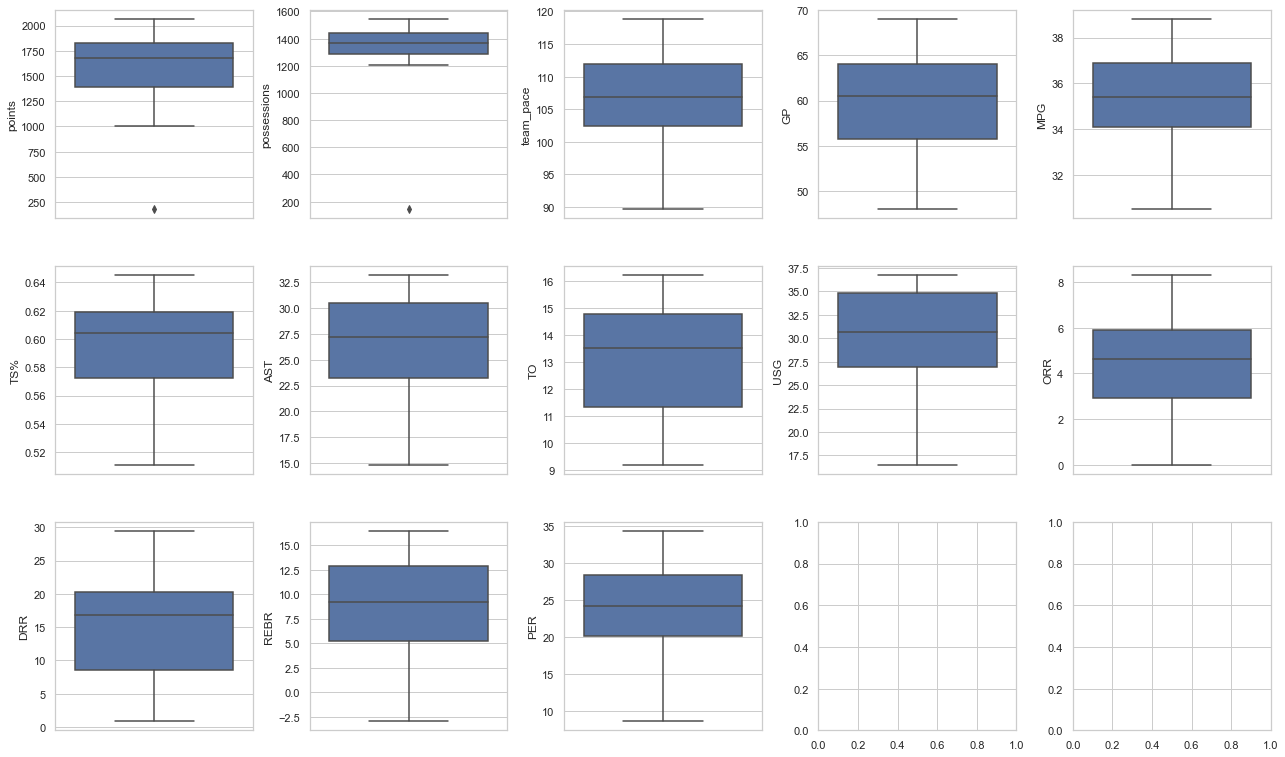

In [12]:
# Create a list of all column names, except for ID.
cols = list(player_df.iloc[:, 1:])

# Create a 3x5 matrix of subplots.
fig, axes = plt.subplots(3, 5, figsize=(18, 11))

# Create padding around subplots to make the axis labels readable.
fig.tight_layout(pad=2.0)

# Loop over the columns of the DataFrame and create a box plot for each one.
for i in range(len(cols)):
    sns.boxplot(ax=axes[i // 5, i % 5], y=player_df[cols[i]])

В `points` и `possessions` вы видите два выброса. Эти выбросы представлены как ромбы в нижней части первых двух диаграмм для столбцов `points` и `possessions`. Значения находятся далеко за пределами диапазона других данных. Скорее всего, это лишние данные, а не игрок с очень плохими результатами.

Здесь важно разбираться в теме. В этом случае, в баскетболе. Вероятность того, что профессиональный игрок получит только одно очко за всю карьеру, чрезвычайно мала. Точно так же мала вероятность того, что у игрока будет на 1400 меньше владений мячом, чем в среднем. Поэтому можно с уверенностью сказать, что это неверные данные.

В другом наборе данных факторы могут отличаться. Поэтому важно тщательно анализировать данные в процессе их обработки.

### Выявление и удаление строк, содержащих выбросы

При необходимости вы можете изучить данные подробнее. Возможно, некоторые данные введены неправильно или повреждены? Если вы разбираетесь в теме или знаете, как данные были собраны, вы можете попытаться исправить ошибочные значения. Но вы рискуете проявить субъективность при изменении данных в наборе. Это негативно повлияет на анализ. Так как в данных осталось 42 записи, скорее всего, лучше удалить ненужные строки.

Блочная диаграмма просто показывает наличие выбросов. Теперь необходимо изучить строки, в которых находятся эти значения.

Так как оба значения находятся ниже минимума для соответствующих столбцов, можно использовать метод `idxmin()` для обоих столбцов. Этот метод возвращает номер индекса строки, в которой находится минимальное значение. (Необходимо отдельно проверить каждое значение.)

In [13]:
# Identify the index number of the row that has the lowest value in 'points'.
points_outlier = player_df['points'].idxmin()
points_outlier

35

In [14]:
# Identify the index number of the row that has the lowest value in 'possession'.
possession_outlier = player_df['possessions'].idxmin()
possession_outlier

35

К счастью, выбросы находятся в одной строке. Теперь вы можете вручную удалить строку, используя функцию `drop()`.

Вы могли бы вручную ввести номер индекса для строки. Но существует риск опечатки. Вместо этого используйте созданную переменную, чтобы указать минимальное значение.

In [15]:
# Drop the row that has the outlying values for 'points' and 'possessions'.
player_df.drop(player_df.index[points_outlier], inplace=True)

# Check the end of the DataFrame to ensure that the correct row was dropped.
player_df.tail(10)

,ID,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
31,36,2062.0,1505.7,111.5,NaN,37.0,0.620,29.8,15.6,36.2,4.9,23.9,14.7,27.86
32,37,1845.0,1435.7,113.1,69.0,36.9,0.634,33.2,14.0,36.5,4.1,21.5,16.4,34.26
33,38,1778.0,1526.4,109.3,66.0,34.9,0.612,30.6,15.9,35.9,5.5,18.8,13.7,28.65
34,39,1901.0,1444.1,109.7,67.0,36.5,0.609,27.2,14.8,35.5,5.0,21.8,8.9,20.12
36,41,2030.0,1431.0,112.3,68.0,37.0,0.618,32.5,15.3,34.5,5.7,15.7,13.2,30.07
37,42,1631.0,1465.7,110.1,66.0,37.5,0.613,28.4,14.4,35.7,6.5,20.7,14.0,28.40
38,43,1828.0,1507.2,112.7,64.0,36.5,0.618,31.3,14.0,34.9,5.9,21.3,14.5,NaN
39,44,1821.0,1443.7,118.8,66.0,36.6,0.609,27.3,13.5,35.8,7.0,23.8,11.5,22.96
40,45,1740.0,1443.9,114.1,68.0,37.1,0.611,26.6,15.2,29.3,8.3,17.7,11.1,21.22
41,46,1993.0,1459.0,112.5,NaN,36.9,0.627,30.4,15.0,33.7,6.3,19.3,14.1,28.76


In [16]:
# Renumber the DataFrame index to reflect the dropped rows.
player_df.reset_index(drop=True, inplace=True)

## Исследование данных, часть 2. Проверка распределения данных

Вы удалили строку с выбросом в столбцах `points` и `possessions`. Но вам по-прежнему необходимо решить вопрос с разбросанными недостающими значениями. Просмотрите эти недостающие значения:

In [17]:
# Recheck the totals for NaN values by row.
player_df.isna().sum()

ID             0
points         0
possessions    0
team_pace      0
GP             6
MPG            5
TS%            0
AST            0
TO             0
USG            0
ORR            0
DRR            0
REBR           0
PER            9
dtype: int64

их немало. Они могут охватывать гораздо больше строк, и вы не хотите отбрасывать столько данных. Можно ли сделать предположение о том, какие значения там должны быть?

В следующей таблице приводятся данные, с которыми вы работаете в этом наборе. Данные в разных столбцах могут вести себя по-разному. Чтобы решить, какие значения следует вставить, нужно опираться на знания по теме.

Одной из распространенных стратегий добавления отсутствующих значений является вставка значения, расположенного непосредственно над или под ним. Но у вас отсутствуют значения скорости, очков, владения мячом и рейтинга эффективности игрока. И вы не знаете порядок игроков в кадре данных. Например, неизвестно, находятся ли последовательные игроки в одной команде. Таким образом, замена отсутствующих значений соседними, вероятно, не является хорошей стратегией.

Другой распространенный прием заключается в замене отсутствующих значений в столбце средним значением этого столбца. Этот метод может подойти для этих столбцов. Но следует проверить, как распределяются данные в каждом столбце.

### Создание гистограмм с данными кадров данных
Распространенным способом визуализации распределения данных является гистограмма. Гистограмма представляет собой линейчатую диаграмму, показывающую, сколько раз данные в наборе отображаются в диапазоне значений. Диапазоны называются *ячейками*. Чтобы создать детализированное представление данных, используйте 30 ячеек в гистограмме.

Ни одна встроенная функция в Python или в популярных библиотеках не позволяет построить несколько гистограмм. Поэтому вы создадите гистограммы с помощью цикла `for`, как вы делали это с блочными диаграммами.

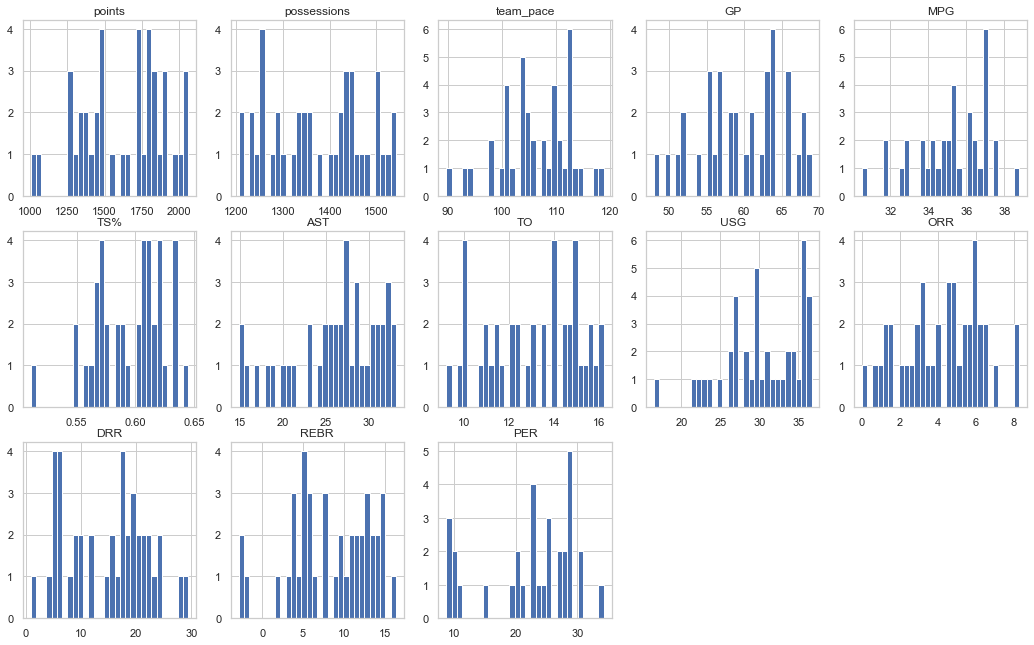

In [18]:
# Create a list of all column names, except for 'ID'.
cols = list(player_df.iloc[:, 1:])

# Define the size for the plots and add padding around them.
fig = plt.figure(figsize=(18, 11))
fig.tight_layout(pad=5.0)

# Loop over the columns in the DataFrame and create a histogram for each one.
for i in range(len(cols)):
    plt.subplot(3, 5, i+1)
    plt.hist(player_df[cols[i]], bins=30)
    plt.title(cols[i])

Большая часть этих гистограмм не показывает нормальное распределение (привычную колоколообразную кривую). Но сложно оценить это невооруженным взглядом. Можно, конечно, использовать меньшее количество ячеек, но вы можете пропустить важные сведения в гистограмме с более низким разрешением. Вместо этого попробуйте использовать другой тип визуализации.

Взгляните на одну гистограмму. Например, гистограмму `GP` (число сыгранных матчей).

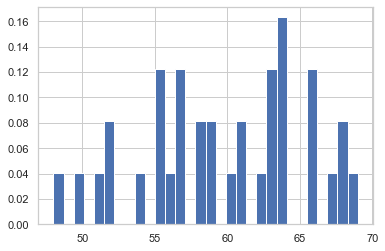

In [20]:
# Create a histogram for the 'GP' column.
plt.hist(player_df['GP'], density=True, bins=30);

В настоящее время гистограмма содержит количество для каждой ячейки. Но вы можете изменить параметр `density` в функции таким образом, чтобы высота каждого столбца в гистограмме показывала долю этого столбца в гистограмме, а не число экземпляров. Иными словами, `density=True` означает, что область столбцов в гистограмме в сумме дает 1.

### Ядерная оценка плотности для данных в кадре
В гистограмме не нужно обязательно использовать прямоугольники. Можно выбрать треугольники, трапеции или даже крошечные колоколообразные кривые Гаусса. Именно для этой фигуры предназначена ядерная оценка плотности. Она создает гистограмму с небольшими колоколообразными кривыми. Область под этими кривыми составляет 1.

Вот как выглядит ядерная оценка плотности для `GP` по сравнению с гистограммой из 15 ячеек:

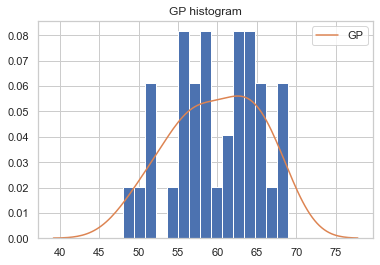

In [21]:
# Plot the KDE for 'GP' over the probability-density histogram.
plt.hist(player_df['GP'], density=True, bins=15)
plt.title('GP histogram')
sns.kdeplot(player_df['GP']);

Ядерная оценка плотности более очевидно, чем диаграмма, показывает, что распределение `GP` похоже на колокольчик с выступом с правой стороны.

Чтобы создать матрицу ядерных оценок плотности для всех столбцов, используйте цикл `for`:

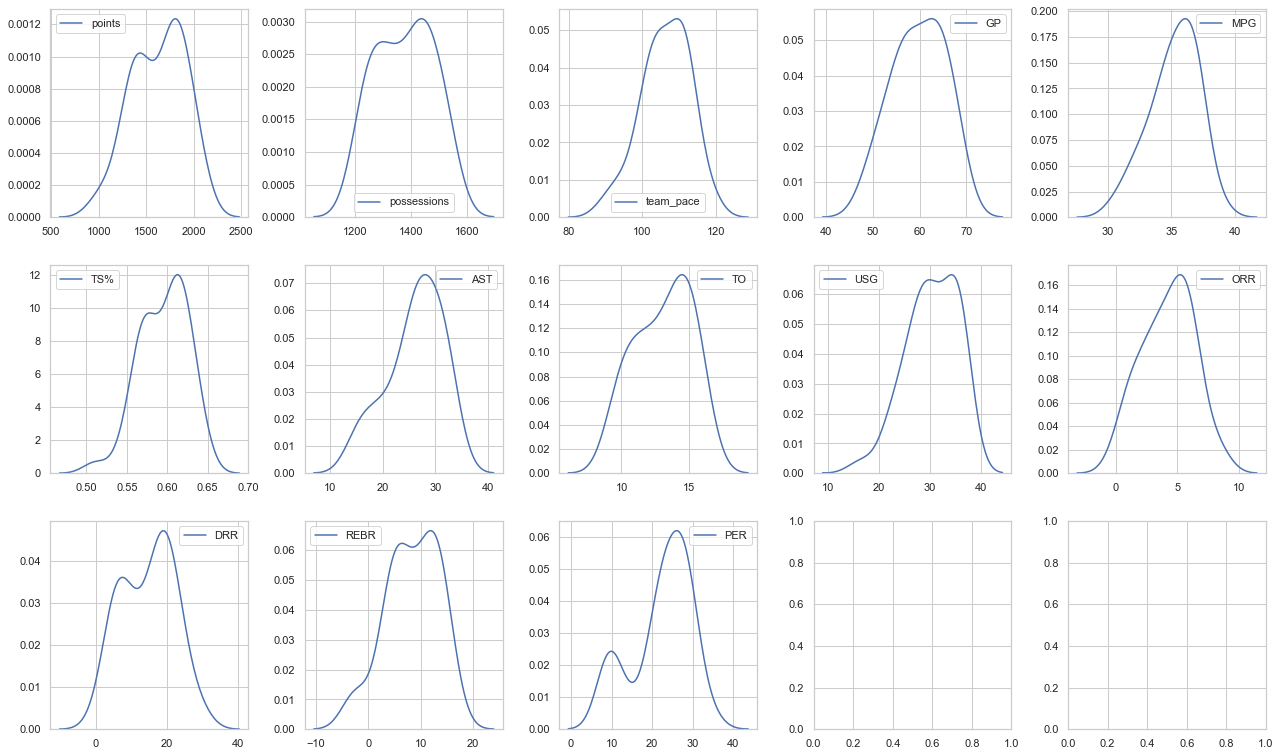

In [22]:
# Create a list of all column names, except for 'ID'.
cols = list(player_df.iloc[:, 1:])

# Create a 3x5 matrix of subplots and add padding around them for readability.
fig, axes = plt.subplots(3, 5, figsize=(18, 11))
fig.tight_layout(pad=2.0)

# Loop over the columns of the DataFrame and create a KDE for each one.
for i in range(len(cols)):
    sns.kdeplot(ax=axes[i//5, i%5], data=player_df[cols[i]])

Конечно, у многих из этих столбцов ядерная оценка плотности показывает две явные вершины. Каждая вершина представляет режим данных или значение, вокруг которого сосредоточены значения в наборе данных. Тот факт, что многие из столбцов имеют бимодальное распределение, указывает на то, что набор данных представляет выборки из двух отдельных совокупностей.

## Исследование данных, часть 3. Обнаружение данных, представляющих более одной совокупности

Для бизнес-анализа данных важно понимать, что данные относятся к двум совокупностям. Например, представьте, что вы анализируете данные о проживании в сфере аренды жилья. Арендаторы, приехавшие в отпуск, и арендаторы, приехавшие по делам, могут вести себя по-разному. Это могут быть разные сроки проживания, времена года или типы необходимых удобств. Будет полезно разделить две совокупности, чтобы составлять различные маркетинговые предложения для каждой из них.

В нашем сценарии с баскетболом вы знаете, что в набор данных входят живые и мультипликационные игроки. Изучите еще несколько бимодальных графов, например `points`, `DRR` и `PER`, и попытайтесь различить две совокупности.

Сначала взгляните на каждое распределение отдельно:

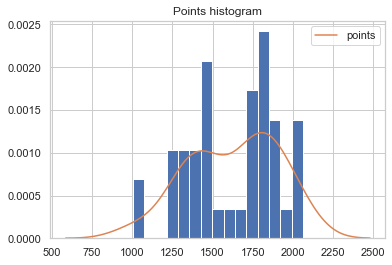

In [23]:
# Plot the KDE for 'points' over the probability-density histogram.
plt.hist(player_df['points'], density=True, bins=15)
plt.title('Points histogram')
sns.kdeplot(player_df['points']);

Вы видите, что в точке 1600 две совокупности разделяются. Эти сведения можно использовать для дальнейшего изучения данных. Например, можно предположить, что игроки Команды Тюнз набирают больше очков, потому что у них есть навыки, которых нет у людей.

Взгляните на строки, в которых игроки набрали более 1600 очков:

In [24]:
player_df.loc[player_df['points'] >= 1600].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 40
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           23 non-null     int64  
 1   points       23 non-null     float64
 2   possessions  23 non-null     float64
 3   team_pace    23 non-null     float64
 4   GP           20 non-null     float64
 5   MPG          20 non-null     float64
 6   TS%          23 non-null     float64
 7   AST          23 non-null     float64
 8   TO           23 non-null     float64
 9   USG          23 non-null     float64
 10  ORR          23 non-null     float64
 11  DRR          23 non-null     float64
 12  REBR         23 non-null     float64
 13  PER          20 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 2.7 KB


В 23 строках есть игроки, которые набрали не менее 1600 очков.

Продолжайте вычислять игроков, которые, скорее всего, входят в Команду Тюнз:

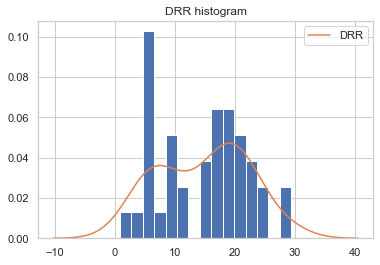

In [25]:
# Plot the KDE for 'DRR' over the probability-density histogram.
plt.hist(player_df['DRR'], density=True, bins=15)
plt.title('DRR histogram')
sns.kdeplot(player_df['DRR']);

Распределение разделяется приблизительно на 15 подборах в защите. Проверьте, помогает ли эта информация точнее определить совокупность игроков из Команды Тюнз.

И снова можно предположить, что игроки Команды Тюнз лучше подбирают мяч в защите, потому что у них есть особые умения. Подсчитайте, сколько игроков (строк) имеют больше 1600 очков и DRR больше 15:

In [26]:
player_df.loc[(player_df['points'] >= 1600) & (player_df['DRR'] >= 15)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 40
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           18 non-null     int64  
 1   points       18 non-null     float64
 2   possessions  18 non-null     float64
 3   team_pace    18 non-null     float64
 4   GP           15 non-null     float64
 5   MPG          16 non-null     float64
 6   TS%          18 non-null     float64
 7   AST          18 non-null     float64
 8   TO           18 non-null     float64
 9   USG          18 non-null     float64
 10  ORR          18 non-null     float64
 11  DRR          18 non-null     float64
 12  REBR         18 non-null     float64
 13  PER          16 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 2.1 KB


Наконец, посмотрим на `PER`, рейтинг эффективности игрока. Если наша гипотеза верна, игроки из Команды Тюнз имеют более высокий `PER`.

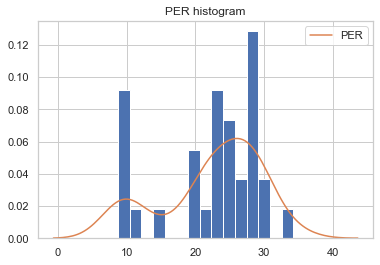

In [27]:
# Plot the KDE for 'PER' over the probability-density histogram.
plt.hist(player_df['PER'], density=True, bins=15)
plt.title('PER histogram')
sns.kdeplot(player_df['PER']);

Распределение разделяется около значения 17. Взгляните на строки, в которых `PER` имеет значение не меньше 17:

In [28]:
player_df.loc[(player_df['points'] >= 1600) & (player_df['DRR'] >= 15) & \
                                                        (player_df['PER'] >= 17)]

,ID,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
26,31,2049.0,1434.0,110.0,64.0,38.8,0.619,31.5,14.9,35.5,8.3,17.6,12.8,28.44
27,32,1795.0,1481.8,112.1,62.0,35.4,0.608,31.9,14.5,32.0,6.5,22.5,12.9,23.34
28,33,1805.0,1509.9,108.6,64.0,35.4,0.622,27.9,13.9,36.0,5.9,27.7,12.2,22.41
30,35,1963.0,1539.1,117.4,NaN,NaN,0.633,32.3,16.2,34.0,5.9,19.8,13.1,27.16
31,36,2062.0,1505.7,111.5,NaN,37.0,0.620,29.8,15.6,36.2,4.9,23.9,14.7,27.86
32,37,1845.0,1435.7,113.1,69.0,36.9,0.634,33.2,14.0,36.5,4.1,21.5,16.4,34.26
33,38,1778.0,1526.4,109.3,66.0,34.9,0.612,30.6,15.9,35.9,5.5,18.8,13.7,28.65
34,39,1901.0,1444.1,109.7,67.0,36.5,0.609,27.2,14.8,35.5,5.0,21.8,8.9,20.12
35,41,2030.0,1431.0,112.3,68.0,37.0,0.618,32.5,15.3,34.5,5.7,15.7,13.2,30.07
36,42,1631.0,1465.7,110.1,66.0,37.5,0.613,28.4,14.4,35.7,6.5,20.7,14.0,28.40


Можно ожидать, что в этих строках находятся игроки Команды Тюнз. В этом модуле в конец набора данных было добавлено 15 игроков Команды Тюнз. Но если бы вы этого не знали, вы могли бы предположить, что данные собраны из двух разных наборов, и второй набор был добавлен после первого.

Строки игроков с идентификаторами 34 и 40 не являются частью этого набора. Хотя индексы 34 и 40 отображаются, идентификаторы 34 и 40 отсутствуют. Вы удалили номер 40 ранее, так как в этой строке было всего 183 очка.

## Обработка данных, часть 1. Добавление важной информации об игроке

Вы определили группы игроков, изучая бимодальные гистограммы. Теперь создайте столбец, указывающий, представляет строка живого или мультипликационного игрока. Затем присвойте каждой строке уникальное имя.

Сначала создайте новый столбец для кадра данных. Для этого составьте список значений для столбца, а затем присвойте ему имя.

In [29]:
# Initialize the list to house the player data.
pop_list = []

# If the ID number is 30 or less, it's a human player; otherwise, it's a Tune Squad player.
for id in player_df['ID']:
    if id <= 30:
        pop_list.append('player' + str(id))
    else:
        pop_list.append('tune_squad' + str(id % 30))

pop_list

['player1',
 'player2',
 'player3',
 'player4',
 'player5',
 'player6',
 'player7',
 'player8',
 'player10',
 'player11',
 'player12',
 'player13',
 'player14',
 'player15',
 'player16',
 'player17',
 'player18',
 'player19',
 'player21',
 'player22',
 'player23',
 'player24',
 'player26',
 'player27',
 'player28',
 'player29',
 'tune_squad1',
 'tune_squad2',
 'tune_squad3',
 'tune_squad4',
 'tune_squad5',
 'tune_squad6',
 'tune_squad7',
 'tune_squad8',
 'tune_squad9',
 'tune_squad11',
 'tune_squad12',
 'tune_squad13',
 'tune_squad14',
 'tune_squad15',
 'tune_squad16']

In [30]:
# Assign this list as the values for the new player column in the DataFrame.
player_df['player'] = pop_list
player_df.head()

,ID,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER,player
0,1,1893.0,1251.8,97.8,63.0,33.9,0.569,17.2,11.5,26.1,4.7,23.3,7.8,10.90,player1
1,2,1386.0,1282.5,110.5,58.0,32.5,0.511,24.8,9.7,26.9,6.1,0.9,10.7,27.30,player2
2,3,1405.0,1252.3,105.8,55.0,36.3,0.605,25.7,13.9,28.1,4.5,4.9,1.8,NaN,player3
3,4,1282.0,1235.9,100.7,54.0,37.6,0.636,29.5,11.0,22.3,4.8,4.6,5.6,22.35,player4
4,5,1721.0,1254.0,105.7,59.0,30.5,0.589,22.8,9.9,24.6,1.2,8.4,12.1,28.38,player5


Если поместить новый столбец в конец, мы столкнемся с проблемой, поскольку последний столбец является расположением по умолчанию для новых столбцов. Поэтому переместите новый столбец справа от `ID`.

Поскольку у вас слишком много столбцов, чтобы можно было вводить значения вручную, составьте список всех столбцов, кроме последнего (теперь это `player`). Используйте метод списка `insert(`), чтобы переместить столбец на второе место в списке. (Помните, что в Python отсчет начинается с нуля!)

Теперь используйте измененный список, чтобы указать порядок столбцов в кадре данных `player_df`.

In [31]:
# Create list of all DataFrame column names but the last one.
column_list = list(player_df.iloc[:, :-1])

# Make player the second item in the list.
column_list.insert(1, 'player')

# Reassign the columns in the player_df DataFrame in this new order.
player_df = player_df[column_list]

# Verify that the columns are ordered the way you expect.
player_df.head()

,ID,player,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
0,1,player1,1893.0,1251.8,97.8,63.0,33.9,0.569,17.2,11.5,26.1,4.7,23.3,7.8,10.90
1,2,player2,1386.0,1282.5,110.5,58.0,32.5,0.511,24.8,9.7,26.9,6.1,0.9,10.7,27.30
2,3,player3,1405.0,1252.3,105.8,55.0,36.3,0.605,25.7,13.9,28.1,4.5,4.9,1.8,NaN
3,4,player4,1282.0,1235.9,100.7,54.0,37.6,0.636,29.5,11.0,22.3,4.8,4.6,5.6,22.35
4,5,player5,1721.0,1254.0,105.7,59.0,30.5,0.589,22.8,9.9,24.6,1.2,8.4,12.1,28.38


Теперь в кадре данных содержатся все данные игроков с новым столбцом игрока, указывающим, относится эта строка к живому игроку или мультипликационному. Как видите, вам по-прежнему нужно заполнить недостающие значения.

## Обработка данных, часть 2. Замещение отсутствующих значений в столбцах

Вы знаете, что значения отсутствуют в разных местах. Еще раз посмотрите на столбцы, в которых отсутствуют значения.

In [32]:
# Recheck the totals for NaN values by row.
player_df.isna().sum()

ID             0
player         0
points         0
possessions    0
team_pace      0
GP             6
MPG            5
TS%            0
AST            0
TO             0
USG            0
ORR            0
DRR            0
REBR           0
PER            9
dtype: int64

Сначала перейдите к гистограммам для `GP` и `MPG`:

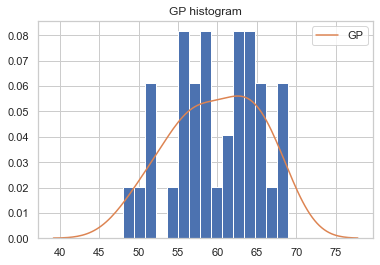

In [33]:
# Plot the KDE for 'GP' over the probability-density histogram.
plt.hist(player_df['GP'], density=True, bins=15)
plt.title('GP histogram')
sns.kdeplot(player_df['GP']);

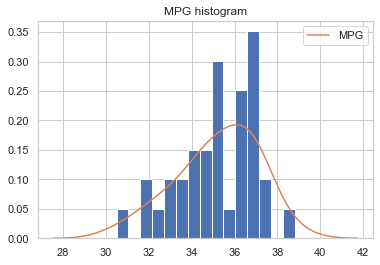

In [34]:
# Plot the KDE for 'MPG' over the probability-density histogram.
plt.hist(player_df['MPG'], density=True, bins=15)
plt.title('MPG histogram')
sns.kdeplot(player_df['MPG']);

Если как следует приглядеться, вы увидите, что `GP` и `MPG` достаточно близки к нормальному распределению, чтобы можно было взять среднее значение и заполнить пробелы в каждом столбце. Но это решение не сработает для `PER`:

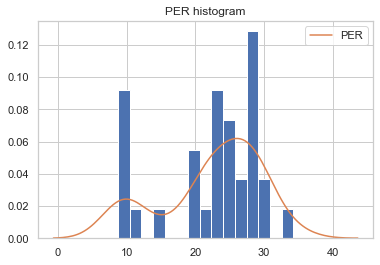

In [35]:
# Plot the KDE for 'PER' over the probability-density histogram.
plt.hist(player_df['PER'], density=True, bins=15)
plt.title('PER histogram')
sns.kdeplot(player_df['PER']);

### Вставка среднего значения вместо недостающего
Чтобы заменить недостающие значения в столбцах с относительно нормальным распределением, используйте метод кадра данных `fillna()`. В коде укажите, что работаете только с двумя столбцами (`player_df[['GP','MPG']]`). Также укажите, что хотите заменить значения `NaN` в каждом из этих столбцов на среднее значение этих столбцов: `fillna(value=player_df[['GP','MPG']].mean())`. (И снова объединение нескольких методов pandas значительно упрощает вашу задачу.)

In [36]:
# Replace the missing values in 'GP' and 'MPG' with the mean values of the respective columns.
player_df[['GP','MPG']] = player_df[['GP','MPG']] \
                   .fillna(value=player_df[['GP','MPG']].mean())

# Recheck the totals for NaN values by row to ensure that the expected missing values are filled in.
player_df.isna().sum()

ID             0
player         0
points         0
possessions    0
team_pace      0
GP             0
MPG            0
TS%            0
AST            0
TO             0
USG            0
ORR            0
DRR            0
REBR           0
PER            9
dtype: int64

Ваши данные почти очищены! Остался всего один столбец.

## Обработка данных, часть 3. Замещение отсутствующих значений с помощью машинного обучения

Как подтверждено `player_df.isna().sum()` в предыдущем уроке, в `PER` остается только девять отсутствующих значений. Нельзя использовать простое среднее значение для замещения значений в этом столбце. Здесь пригодится некоторый опыт в этой области.

Рейтинг эффективности игрока рассчитывается на основе значений девяти столбцов, предшествующих ему в кадре данных (`GP` через `REBR`). Однако вычислить рейтинг эффективности игрока довольно сложно (дополнительные сведения см. на сайте basketball-reference.com). Вы выполните задачи по анализу и обработке данных, то есть создадите модель, чтобы рассчитать приближенную величину.

Можно создать простую модель линейной регрессии для вычисления недостающих значений `PER`. Однако нужно быть уверенным, что эти приблизительные значения близки к истине.

Чтобы получить представление о точности модели, можно использовать машинное обучение и разделить данные на две части: для тестирования и обучения. Обучающий набор — это часть данных, используемых для обучения модели. Для проверки модели используется второй набор. Обычно для обучения модели используется 75% данных, а для проверки модели — 25%.

Но что делать, если вам слишком повезло или не повезло при случайном разделении данных на тестовые и обучающие? Например, что если вы обучали модель на данных живых игроков, а затем тестировали ее точность на игроках Команды Тюнз? Скорее всего, результаты будут неточными.

Чтобы избежать этой проблемы, специалисты по статистике и анализу и обработке данных используют метод перекрестной проверки. Идея состоит в том, чтобы выполнить итерацию по набору данных, различными способами разделяя данные на обучающие и тестовые. Если использовать этот метод несколько раз, вы получите представление о том, как модель будет работать с новыми данными, даже если у вас мало данных для работы.

### Перекрестная проверка оценок R2 для модели
Здесь вы будете использовать перекрестную проверку в 10-кратном порядке. Это значит, что Python будет перебирать данные 10 раз, каждый раз резервируя 10% данных для тестирования и обучения для остальных 90%. Вы создадите гистограмму результатов.

> При чтении кода Python помните, что вы определяете прогнозные факторы как `X` в соответствии с давно существующим соглашением. Затем используйте атрибут кадра данных `iloc`, чтобы выбрать столбцы по номеру, а не по имени `(iloc[:, 4:-1])`. Наконец, используйте только значения из результирующего среза кадра данных, а не среза в форме кадров данных. (Здесь предпочтительнее использовать метод `to_numpy()`, а не атрибут кадра данных `values`, как в документации по `pandas.DataFrame.values`.)

Код прогнозируемого значения `y` аналогичен коду для `X`, за исключением того, что вам не нужно извлекать только значения.

Mean r2 score: 0.9995
10% of r2 scores are between 0.9985 and 0.9987
10% of r2 scores are between 0.9987 and 0.9988
10% of r2 scores are between 0.9995 and 0.9996
10% of r2 scores are between 0.9996 and 0.9997
60% of r2 scores are between 0.9997 and 0.9998


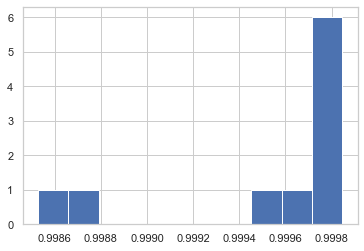

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Define the variables for the regression model as those rows that have no missing values.
X = player_df.dropna(how='any').iloc[:, 5:-1].to_numpy()
y = player_df.dropna(how='any').iloc[:, -1]

# Define the regression model.
lin_reg = LinearRegression()

# Use the scikit-learn cross-validation function to fit this model 10 times and return the R2 scores.
scores = cross_val_score(lin_reg, X, y, cv=10, scoring='r2')

# Define the histogram of the scores and copy out information from the histogram.
entries, bin_edges, patches = plt.hist(scores, bins=10)

# Print out the mean and the results from the histogram.
print('Mean r2 score: {:.4f}'.format(scores.mean()))
for i in range(len(entries)):
    if entries[i] > 0:
        print('{:.0f}% of r2 scores are between {:.4f} and {:.4f}' \
              .format(entries[i]*100 / len(entries), 
              bin_edges[i], 
              bin_edges[i+1]))

Оценка $R^2$ составляет 99,95%. Оценка $R^2$ (т. е. R в квадрате) показывает, какую степень вариантности данных захватывает модель. В нашем случае эта оценка примерно показывает точность модели. Нас устраивает даже самый низкий из наших показателей $R^2$, а большинство из них близки к максимальному значению 1. Так что вы можете уверенно применить эту модель к отсутствующим значениям `PER`.

> Точные результаты $R^2$ могут немного отличаться. Каждый раз, когда вы запускаете эту модель, вы получаете различные случайные выборки данных при всех 10 попытках. Поэтому модель может быть немного лучше или хуже при каждом запуске. Однако ваши результаты должны быть почти такими же, как в примерах.

### Подгонка модели регрессии для данных игроков
Теперь вы подгоните модель регрессии для всех данных. (Как правило, вы должны использовать перекрестную проверку для выбора или оценки модели, а для ее создания вам понадобятся все данные.)

In [38]:
# Fit the same regression model, this time using all of the available data.
lin_reg.fit(X, y)

LinearRegression()

### Создание маски строк, в которых используются отсутствующие значения в кадре данных

У нас нет элегантного способа для `fillna()`, чтобы использовать результаты из модели для заполнения недостающих значений `PER`. Поэтому необходимо использовать маску.

Маска в pandas — это логическая схема значений, удовлетворяющих определенному условию или набору условий. Чтобы заполнить только оставшиеся значения, маска должна выглядеть следующим образом:

In [39]:
# Create and display a mask of rows in the DataFrame. Rows should contain at least one NaN value.
mask = player_df.isnull().any(axis=1)
mask

0     False
1     False
2      True
3     False
4     False
5     False
6     False
7      True
8      True
9     False
10    False
11     True
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19    False
20     True
21    False
22    False
23    False
24     True
25    False
26    False
27    False
28    False
29     True
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37     True
38    False
39    False
40    False
dtype: bool

Теперь примените эту маску только к столбцам, которые использовались в качестве `X` в модели. Используйте метод кадра данных `loc`:

In [40]:
# Apply the mask defined earlier to show the contents of specific columns of rows that contain NaN values.
player_df.loc[mask].iloc[:, 5:-1]

,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR
2,55.000000,36.300000,0.605,25.7,13.9,28.1,4.5,4.9,1.8
7,57.000000,35.208333,0.574,24.4,11.3,26.3,5.5,5.8,-2.2
8,61.000000,35.600000,0.547,22.9,12.2,22.7,5.8,6.4,-2.9
11,59.771429,31.700000,0.584,32.4,14.7,16.5,3.2,19.0,4.1
15,59.771429,34.900000,0.603,26.2,11.1,36.7,3.0,14.3,5.3
20,61.000000,35.208333,0.645,20.6,13.1,31.5,4.0,12.0,5.2
24,48.000000,35.100000,0.569,19.0,10.9,29.2,4.6,17.7,5.2
29,64.000000,36.300000,0.619,30.9,15.6,34.5,5.9,18.9,14.8
37,64.000000,36.500000,0.618,31.3,14.0,34.9,5.9,21.3,14.5


Итак, вы определили девять строк, которые имеют значение `NaN` в столбце `PER` и имеют столбцы, которые можно использовать в модели машинного обучения для прогнозирования рейтинга эффективности игрока.

### Используйте маску и подогнанную маску для замещения конечных отсутствующих значений в кадре данных
Преимущество маски в данном случае в том, что она позволяет использовать представление кадра данных `player_df`, а не его срез. При определении `X` вы использовали `player_df.dropna(how='any').iloc[:, 5:-1].to_numpy()`. Метод `dropna()` создает новый объект кадра данных по умолчанию при вызове. Именно из-за этой функции вы использовали параметр `inplace` метода в исходном кадре данных. Таким образом, любые изменения значений, которые вы можете внести в кадр данных `X`, не приводят к изменению значений в кадре данных `player_df`.

Маска отличается. Она просто позволяет работать с набором кадра данных `player_df`. Таким образом, любые изменения, вносимые в кадр данных во время применения маски, также применяются ко всему кадру данных `player_df`.

In [41]:
# Impute the missing values in 'PER' by using the regression model and mask.
player_df.loc[mask, 'PER'] = lin_reg.predict(player_df.loc[mask].iloc[:, 5:-1])

# Recheck the DataFrame for rows that have missing values.
player_df.isna().sum()

ID             0
player         0
points         0
possessions    0
team_pace      0
GP             0
MPG            0
TS%            0
AST            0
TO             0
USG            0
ORR            0
DRR            0
REBR           0
PER            0
dtype: int64

Затем просмотрите весь кадр данных, чтобы проверить отсутствующие значения.

In [42]:
# Display the entire DataFrame.
player_df

,ID,player,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
0,1,player1,1893.0,1251.8,97.8,63.000000,33.900000,0.569,17.2,11.5,26.1,4.7,23.3,7.8,10.900000
1,2,player2,1386.0,1282.5,110.5,58.000000,32.500000,0.511,24.8,9.7,26.9,6.1,0.9,10.7,27.300000
2,3,player3,1405.0,1252.3,105.8,55.000000,36.300000,0.605,25.7,13.9,28.1,4.5,4.9,1.8,16.595759
3,4,player4,1282.0,1235.9,100.7,54.000000,37.600000,0.636,29.5,11.0,22.3,4.8,4.6,5.6,22.350000
4,5,player5,1721.0,1254.0,105.7,59.000000,30.500000,0.589,22.8,9.9,24.6,1.2,8.4,12.1,28.380000
5,6,player6,1004.0,1322.4,102.1,57.000000,36.300000,0.574,20.3,13.5,31.0,1.2,20.5,3.4,9.830000
6,7,player7,1920.0,1207.6,109.8,55.000000,37.000000,0.573,26.0,13.1,30.7,0.0,10.3,-2.6,8.710000
7,8,player8,1353.0,1348.1,112.2,57.000000,35.208333,0.574,24.4,11.3,26.3,5.5,5.8,-2.2,8.717454
8,10,player10,1468.0,1400.9,93.7,61.000000,35.600000,0.547,22.9,12.2,22.7,5.8,6.4,-2.9,3.115350
9,11,player11,1856.0,1303.8,93.4,55.000000,33.600000,0.563,28.9,14.7,26.7,1.4,17.3,4.3,9.670000


Наконец, сохраните этот кадр данных в CSV-файл. Этот набор данных будет использоваться для принятия решений до матча и во время него с учетом игроков в команде, игроков, которые сейчас находятся на площадке, и текущей статистики матча.

> Параметр `index=False` гарантирует, что индекс, который был добавлен в кадр данных при первоначальном чтении CSV-файла в pandas, не записывается в CSV-файл.

In [43]:
player_df.to_csv('player_data_final.csv', index=False)

## Подготовка данных путем добавления квалификаторов строк

Кадр данных Pandas `player_df` содержит данные 40 игроков. Первые 26 строк представляют собой людей, а последние 17 строк — мультипликационных персонажей. Мы собираемся создать приложение, которое будет помогать тренеру в выборе того, кого из игроков следует отправить на перерыв во время игры без риска игровому процессу, а также без выматывания других игроков на площадке. В этом модуле мы будем использовать только данные Команды Тюнз. Итак, мы сосредоточимся на последних 16 строках данных.

Прежде чем приступить к созданию приложения, необходимо убедиться, что данные находятся в состоянии, которое обеспечит их прием приложением.

Начнем с создания кадра данных, представляющего только Команду Тюнз. Этот код выбирает все строки, начиная со строки 27 (индекс 26, поскольку отсчет в таблице данных начинается с нуля), и все столбцы:

In [45]:
# Create a DataFrame of only Tune Squad players.
ts_df = player_df.iloc[26: , :]
ts_df

,ID,player,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
26,31,tune_squad1,2049.0,1434.0,110.0,64.000000,38.800000,0.619,31.5,14.9,35.5,8.3,17.6,12.8,28.440000
27,32,tune_squad2,1795.0,1481.8,112.1,62.000000,35.400000,0.608,31.9,14.5,32.0,6.5,22.5,12.9,23.340000
28,33,tune_squad3,1805.0,1509.9,108.6,64.000000,35.400000,0.622,27.9,13.9,36.0,5.9,27.7,12.2,22.410000
29,34,tune_squad4,1743.0,1422.4,112.9,64.000000,36.300000,0.619,30.9,15.6,34.5,5.9,18.9,14.8,29.853138
30,35,tune_squad5,1963.0,1539.1,117.4,59.771429,35.208333,0.633,32.3,16.2,34.0,5.9,19.8,13.1,27.160000
31,36,tune_squad6,2062.0,1505.7,111.5,59.771429,37.000000,0.620,29.8,15.6,36.2,4.9,23.9,14.7,27.860000
32,37,tune_squad7,1845.0,1435.7,113.1,69.000000,36.900000,0.634,33.2,14.0,36.5,4.1,21.5,16.4,34.260000
33,38,tune_squad8,1778.0,1526.4,109.3,66.000000,34.900000,0.612,30.6,15.9,35.9,5.5,18.8,13.7,28.650000
34,39,tune_squad9,1901.0,1444.1,109.7,67.000000,36.500000,0.609,27.2,14.8,35.5,5.0,21.8,8.9,20.120000
35,41,tune_squad11,2030.0,1431.0,112.3,68.000000,37.000000,0.618,32.5,15.3,34.5,5.7,15.7,13.2,30.070000


Давайте рассмотрим эти данные чуть подробнее. Как видно, некоторые заголовки столбцов являются аббревиатурами. Давайте разберем заголовки столбцов:

- `ID`: уникальный идентификатор для каждого игрока в наборе данных
- `player`: уникальный идентификатор, созданный для отслеживания того, какой игрок является мультипликационным персонажем, а кто — человеком
- `points`: всего очков, полученных игроком за сезон
- `possessions`: общий показатель владения мячом для игрока за сезон
- `team_pace`: средний показатель владения мячом для команды в каждом матче
- `GP`: число матчей, проведенных игроком за сезон
- `MPG`: среднее число минут, проведенных игроком на площадке, за матч
- `TS%`: показатель эффективности бросков с учетом штрафных и трехочковых бросков
- `AST`: коэффициент голевых передач — процент владений мячом, которые закончились голевой передачей
- `TO`: коэффициент потери мяча — процент владений мячом, которые закончились потерей мяча
- `USG`: коэффициент использования, количество владений мячом для игрока за 40 минут
- `ORR`: коэффициент подбора в нападении
- `DRR`: коэффициент подбора в защите
- `REBR`: коэффициент подбора, процент пропущенных ударов, которые игрок подбирает
- `PER`: рейтинг эффективности игрока — показатель продуктивности игрока на площадке в минуту

Несмотря на то, что многие из этих точек данных имеют смысл в контексте баскетбола, мы можем начать очистку наших данных даже без глубокого технического понимания каждого из этих столбцов. Поэтому, если вам не знакомы какие-либо из этих терминов, не беспокойтесь! Нам есть чем заняться для анализа имеющихся данных.

Важно понимать, что каждый из этих столбцов содержит данные, которые могут быть подсчитаны во время игры, кроме столбца `PER`.

`PER` не является идеальным показателем, и некоторые болельщики и специалисты по обработке и анализу данных могут по-разному оценивать игрока. Однако в этом модуле мы будем использовать `PER` в качестве меры, которая поможет тренеру более эффективно принимать решения о том, какого игрока следует отправить на перерыв во время матча.

### Импорт данных Команды Тюнз для объединения с данными игроков
Далее нам необходимо импортировать имена мультипликационных персонажей. Прежде чем перейти к следующему шагу, откройте файл tune_squad.csv. Вы увидите, что данные в файле разделены символами табуляции, а не запятыми, поэтому в вызове `pd.read_csv()` задайте `sep='\t'`:

In [46]:
# Import Tune Squad player names.
ts_name_df = pd.read_csv('https://raw.githubusercontent.com/sguthals/learnwithdrg/main/SpaceJamANewLegacy/tune_squad.csv', sep='\t')
ts_name_df

,ID,player
0,31,Sylvester
1,32,Marvin the Martian
2,33,Road Runner
3,34,Foghorn Leghorn
4,35,Bugs Bunny
5,36,Elmer Fudd
6,37,Lola Bunny
7,38,Porky Pig
8,39,Tasmanian Devil
9,40,Yosemite Sam


Кадр данных `ts_names_df` содержит идентификатор игрока, который соответствует идентификатору в основном кадре данных, и фактическое имя игрока.

### Объединение кадров данных для лучшего соответствия
Теперь у нас есть два кадра данных, которые содержат дополняющие данные. Мы можем объединить кадры данных в столбце `ID`, поскольку понимаем, что эти столбцы совпадают:

In [47]:
# Merge the two DataFrames.
ts_df = pd.merge(ts_df, ts_name_df, on='ID', how='left', suffixes=('_type', '_name'))
ts_df.head()

,ID,player_type,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER,player_name
0,31,tune_squad1,2049.0,1434.0,110.0,64.000000,38.800000,0.619,31.5,14.9,35.5,8.3,17.6,12.8,28.440000,Sylvester
1,32,tune_squad2,1795.0,1481.8,112.1,62.000000,35.400000,0.608,31.9,14.5,32.0,6.5,22.5,12.9,23.340000,Marvin the Martian
2,33,tune_squad3,1805.0,1509.9,108.6,64.000000,35.400000,0.622,27.9,13.9,36.0,5.9,27.7,12.2,22.410000,Road Runner
3,34,tune_squad4,1743.0,1422.4,112.9,64.000000,36.300000,0.619,30.9,15.6,34.5,5.9,18.9,14.8,29.853138,Foghorn Leghorn
4,35,tune_squad5,1963.0,1539.1,117.4,59.771429,35.208333,0.633,32.3,16.2,34.0,5.9,19.8,13.1,27.160000,Bugs Bunny


### Упорядочение кадров данных для повышения удобочитаемости
С технической точки зрения, не имеет значения, где находится каждый столбец в кадре данных, однако разместив имя игрока слева, рядом с его идентификатором, мы повысим удобочитаемость данных.

Чтобы переместить этот столбец, чтобы он находился рядом со столбцом `ID`, выполните следующие действия:

- Создайте список столбцов.
- Удалите столбец `player_name` из списка (нам известно, что он находится в конце, поэтому мы можем просто удалить его из списка).
- Поместите `player_name` вторым в списке столбцов, заменив столбец `player_type`.
- Присвойте нашему кадру данных новое расположение столбцов.

In [48]:
# Rearrange the columns to put the ID and player_name columns next to each other.
column_list = list(ts_df)

player_name = column_list.pop()
column_list[1] = player_name

ts_df = ts_df[column_list]
ts_df.head()

,ID,player_name,points,possessions,team_pace,GP,MPG,TS%,AST,TO,USG,ORR,DRR,REBR,PER
0,31,Sylvester,2049.0,1434.0,110.0,64.000000,38.800000,0.619,31.5,14.9,35.5,8.3,17.6,12.8,28.440000
1,32,Marvin the Martian,1795.0,1481.8,112.1,62.000000,35.400000,0.608,31.9,14.5,32.0,6.5,22.5,12.9,23.340000
2,33,Road Runner,1805.0,1509.9,108.6,64.000000,35.400000,0.622,27.9,13.9,36.0,5.9,27.7,12.2,22.410000
3,34,Foghorn Leghorn,1743.0,1422.4,112.9,64.000000,36.300000,0.619,30.9,15.6,34.5,5.9,18.9,14.8,29.853138
4,35,Bugs Bunny,1963.0,1539.1,117.4,59.771429,35.208333,0.633,32.3,16.2,34.0,5.9,19.8,13.1,27.160000


В коде для изменения порядка столбцов (столбец `player_type` не требуется, поскольку теперь у нас есть имена игроков) было проще заменить столбец на `player_name`. Нам не пришлось явно удалять столбец `player_type`!

## Создание модели машинного обучения на основе данных игроков

Наша цель состоит в том, чтобы использовать данные о каждом игроке Команды Тюнз для принятия решений во время матча. Мы будем использовать `PER`, поскольку это поминутное измерение результативности игрока на площадке. Несмотря на то, что в профессиональном баскетболе показатель `PER` игрока вычисляется на основе его результативности в течение всего сезона, мы можем использовать `PER` в качестве нестрогого приблизительного значения результативности игрока в одном матче. В этом случае для использования PER для каждого игрока потребуется следующая статистика:

- `TS%`: показатель эффективности бросков с учетом штрафных и трехочковых бросков
- `AST`: процент владений мячом, которые закончились голевой передачей
- `TO`: процент владений мячом, которые закончились потерей мяча
- `USG`: количество владений мячом для игрока за 40 минут
- `ORR`: коэффициент подбора игрока в нападении
- `DRR`: коэффициент подбора игрока в защите
- `REBR`: процент пропущенных ударов, которые игрок подбирает

> С технической точки зрения в показателе PER также учитывается количество сыгранных матчей и количество минут, проведенных на площадке во время матча. Поскольку эта статистика охватывает несколько игр, мы не будем учитывать ее.

У нас нет реальной игры, за которой можно наблюдать, поскольку фильм выйдет только летом 2021 г. Но мы можем смоделировать игру, используя математические вычисления!

Мы будем использовать стандартное отклонение статистики игроков, чтобы смоделировать их игру. Поскольку у нас нет данных за несколько игр для наших игроков, мы будем использовать стандартное отклонение каждой статистики для имеющихся игроков.

Конечно, этот подход не даст нам точного представления о том, чего можно ожидать от игроков в реальной игре, но мы можем использовать эти данные для достижения нашей основной цели: изучения того, как мы можем использовать обработку и анализ данных в реальном сценарии.

По завершении работы с этим модулем вы сможете использовать фактическую статистику игрока и матчей, чтобы проверить, эффективен ли этот подход в реальной жизни.

Чтобы упростить это, создадим серию уточняющих запросов Pandas для каждого стандартного отклонения статистики. По сути, ряды представляют собой кадр данных с одним столбцом. Задайте имена статистики в качестве индекса ряда, чтобы упростить их поиск в дальнейшем.

In [50]:
# Create a list of only the column names we are interested in.
game_stat_cols = list(ts_df.iloc[:, 7:-1])
game_stat_stdevs = []

# Create a list of standard deviations for each stat.
for stat in game_stat_cols:
    game_stat_stdevs.append(ts_df[stat].std())

# Create a Series of the standard deviations, with the stat names as the index.
stdev_s = pd.Series(game_stat_stdevs, index=game_stat_cols)
stdev_s

TS%     0.008262
AST     2.140494
TO      0.797197
USG     1.892718
ORR     1.139465
DRR     3.017962
REBR    1.802564
dtype: float64

С помощью этого ряда можно смоделировать данные игрока. Мы хотим узнать, поможет ли `PER` игрока, учитывая наши обширные предположения, выбрать подходящего игрока: следует ли отправить игрока на перерыв или оставить его на площадке?

### Обучение модели машинного обучения на основе данных игроков
Чтобы обучить модель машинного обучения для прогнозирования PER игрока на основе определенной статистики игрока в смоделированной игре, мы будем использовать все данные, которые мы первоначально скачали, включая данные об игроке. Для этого необходимо разделить данные на две части:

- $X$: входные данные, используемые для прогнозирования $y$;
- $\hat y$: выходное значение, которое должна спрогнозировать модель машинного обучения.

Входные данные $X$ — это все данные, которые должна использовать модель машинного обучения для прогнозирования выходных данных $y$. В этом случае нам требуется $X$ для представления семи столбцов, которые интересуют нас в первую очередь. Выходные данные $y$ — это число, которое нужно спрогнозировать, когда учитываются все столбцы в $X$. В нашем случае $y$ будет `PER`. Чтобы создать эти две переменные, нам нужно просто взять последние восемь столбцов, за исключением последнего столбца, и использовать его для $X$. Мы возьмем только последний столбец, который будет использоваться для $y$.

In [52]:
# Get the dependent and independent variables for modeling the PER.
X = player_df.iloc[:, 7:-1].to_numpy()
y = player_df.iloc[:, -1]

Далее нам нужно обучить модель машинного обучения (или подогнать ее). Мы используем библиотеку `scikit-learn.LinearRegression`, которая является предварительно написанной моделью машинного обучения линейной регрессии, которая автоматически определит, как спрогнозировать $y$ на основе $X$. 

In [53]:
# Define and fit the model.
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

Этот код модели машинного обучения `lin_reg`, которую можно использовать для прогнозирования `PER` на основе набора семи входных статистических данных, которые мы применили для обучения модели `TS%`, `AST`, `TO`, `USG`, `ORR`, `DRR` и `REBR`.

### Тестирование модели машинного обучения с использованием случайных чисел на основе стандартного отклонения
После подгонки модели ее можно использовать для прогнозирования `PER` на основе новых данных в семи столбцах. Давайте рассмотрим, как работает эта модель. Мы можем использовать эту модель для прогнозирования `PER` для случайных данных для игроков по 10 итерациям.

Для каждой итерации мы выполним следующие действия:

- Создайте пустой кадр данных, содержащий только имена игроков.
- Для каждой статистики игрока создайте случайное число в пределах стандартного отклонения для этого игрока.
- Сохраните созданное случайным образом число в кадре данных.
- Спрогнозируйте `PER` для каждого игрока в зависимости от нового кадра данных случайных чисел.
- Выполните печать каждой итерации с игроком с самым низким `PER` и игроком с самым высоким `PER`.

In [55]:
from numpy.random import randn

# Print the player with the highest and lower PER for each iteration.
print('Iteration # \thigh PER \tlow PER')

# Run the simulation 10 times.
for i in range(10):

    # Define an empty temporary DataFrame for each iteration.
    # The columns of this DataFrame are the player stats and the index is the players' names.
    game_df = pd.DataFrame(columns=game_stat_cols, index=list(ts_df['player_name']))
    
    # Loop through each stat.
    for stat in game_stat_cols:
        
        # Each player's stats are used to generate a random value for each iteration.
        game_df[stat] = list(ts_df[stat] + randn(len(ts_df)) * stdev_s[stat])
    
    # Use the fitted model to predict players' PERs based on the randomized data.
    game_df['PER'] = lin_reg.predict(game_df)

    # Print the player with the highest and lower PER for each iteration.
    print('Iteration {}'.format(i+1) + ' \t' + game_df['PER'].idxmax() + ' \t' + game_df['PER'].idxmin())

Iteration # 	high PER 	low PER
Iteration 1 	Foghorn Leghorn 	Tweety
Iteration 2 	Lola Bunny 	Road Runner
Iteration 3 	Lola Bunny 	Penelope
Iteration 4 	Lola Bunny 	Tasmanian Devil
Iteration 5 	Lola Bunny 	Penelope
Iteration 6 	Granny 	Tasmanian Devil
Iteration 7 	Wile E. Coyote 	Penelope
Iteration 8 	Lola Bunny 	Penelope
Iteration 9 	Lola Bunny 	Road Runner
Iteration 10 	Lola Bunny 	Tweety


Таким образом, если у нас есть данные об игре, а не случайные значения, основанные на стандартном отклонении, мы могли бы запросто передать данные в эту модель машинного обучения и определить, какого игрока (с самым низким `PER`) следует отправить на перерыв, а кто должен остаться на площадке (с самым высоким `PER`).

По мере игры статистика для каждого игрока меняется. Если мы видим, что высокий показатель `PER` игрока начинает снижаться, его следует отправить на перерыв. Снижение показателя `PER`, скорее всего, указывает на то, что игрок начинает уставать.

## Использование машинного обучения и стандартного отклонения для создания фиктивных данных игры

У нас возникла проблема — невозможно получить данные реальной игры Команды Тюнз. У нас нет возможности посмотреть, как 15 персонажей Команды Тюнз играют в баскетбол, и протестировать нашу модель в фактическом приложении.

Однако мы можем использовать прием, которому научились во время тестирования нашей модели, чтобы создать новый набор данных, имитирующий игру!

Это поможет нам решить, какого игрока следует отправлять на перерыв каждые 12 минут в стандартном 48-минутном матче. Поэтому следует создать CSV-файл, который будет содержать случайные данные игрока в четырех таймах: 0 минут (начало игры), 12 минут, 24 минуты и 36 минут:

In [59]:
# Initialize four empty DataFrames, one for each 12-minute period.
number_of_iterations = 4
df_list = [pd.DataFrame(columns=game_stat_cols, index=list(ts_df['player_name'])) for i in range(number_of_iterations)]

# For each period, generate randomized player data and predict the PER.
# Use the model fitted earlier.
for df in df_list:
    for stat in game_stat_cols:
        df[stat] = list(ts_df[stat] + randn(len(ts_df)) * stdev_s[stat])
    df['PER'] = lin_reg.predict(df)

# Concatenate the DataFrames and make the players' names the index.
game_df = pd.concat(df_list)
game_df.rename_axis('player_name', inplace=True)

# Create another index for the period in question.
minutes = [(x // len(ts_df)) * 12 for x in range(len(game_df))]
game_df['minutes'] = minutes
game_df.set_index('minutes', append=True, inplace=True)
game_df = game_df.swaplevel()

game_df

TS%        AST         TO        USG  \
minutes player_name                                                     
0       Sylvester           0.631545  34.252576  15.173689  39.643242   
        Marvin the Martian  0.603172  32.231644  14.388546  32.469308   
        Road Runner         0.625119  25.027566  12.965302  37.001595   
        Foghorn Leghorn     0.633880  30.428918  15.217534  33.060875   
        Bugs Bunny          0.635937  33.812335  16.774276  34.162278   
        Elmer Fudd          0.618276  28.654277  15.703053  36.551633   
        Lola Bunny          0.641627  35.796551  13.045496  36.168242   
        Porky Pig           0.610923  29.208524  15.872318  34.733786   
        Tasmanian Devil     0.616003  32.274784  14.655433  35.849014   
        Gossamer            0.606861  32.192313  17.555900  34.153940   
        Granny              0.625294  27.192763  14.199292  31.324857   
        Wile E. Coyote      0.616242  30.252736  14.094087  37.002446   
        Tweety              0.592552  27.079158  13.137833  34.072854   
        Penelope            0.613669  25.477018  13.861002  31.485793   
        Daffy Duck          0.653403  31.190002  15.234505  31.789035   
12      Sylvester           0.625790  32.506440  15.062835  38.852066   
        Marvin the Martian  0.609070  33.012822  14.251829  33.610905   
        Road Runner         0.612956  28.406996  13.448485  38.922853   
        Foghorn Leghorn     0.638851  25.723243  16.157674  35.463131   
        Bugs Bunny          0.643140  29.299220  18.246456  31.948841   
        Elmer Fudd          0.624078  28.701142  15.481255  37.053660   
        Lola Bunny          0.647851  34.254907  13.028240  35.249606   
        Porky Pig           0.595330  30.858105  16.449686  37.414347   
        Tasmanian Devil     0.595812  26.307546  14.693849  37.088918   
        Gossamer            0.625189  30.926107  15.038897  35.825679   
        Granny              0.612314  28.819692  14.281774  35.352670   
        Wile E. Coyote      0.611901  30.192895  14.100232  35.467241   
        Tweety              0.611387  23.199682  13.221426  36.155233   
        Penelope            0.603415  27.008303  14.875842  29.390722   
        Daffy Duck          0.602542  29.930194  15.151997  32.925847   
24      Sylvester           0.616604  31.999528  15.662567  37.653884   
        Marvin the Martian  0.590414  30.403439  13.113495  31.696197   
        Road Runner         0.631001  29.650541  13.572732  36.319708   
        Foghorn Leghorn     0.605684  31.340263  16.144366  36.981103   
        Bugs Bunny          0.632378  30.365958  16.165926  36.514887   
        Elmer Fudd          0.624659  32.402489  15.462481  33.907085   
        Lola Bunny          0.647889  31.519271  12.793770  35.836149   
        Porky Pig           0.628850  33.495138  16.359277  34.950752   
        Tasmanian Devil     0.614159  27.701635  16.745541  37.998986   
        Gossamer            0.612286  30.190483  14.835708  35.496251   
        Granny              0.609784  26.445682  14.899002  35.399419   
        Wile E. Coyote      0.619212  29.583363  14.182420  32.803912   
        Tweety              0.613309  26.609769  10.360107  36.146240   
        Penelope            0.616450  28.186925  15.083955  29.278966   
        Daffy Duck          0.633206  30.375596  14.740914  32.026130   
36      Sylvester           0.621079  32.841343  15.355026  35.914817   
        Marvin the Martian  0.614316  30.043905  14.029172  34.442213   
        Road Runner         0.616084  27.070513  13.854903  39.799557   
        Foghorn Leghorn     0.622481  33.274079  14.916336  33.198345   
        Bugs Bunny          0.634885  35.466050  15.574753  33.975251   
        Elmer Fudd          0.618299  31.400977  17.216520  34.903807   
        Lola Bunny          0.628929  34.889223  14.022809  35.374554   
        Porky Pig           0.610275  33.355959  14.718232  37.699903   
        Tasmanian 

Итак, кадр данных готов. Мы можем сохранить его в виде CSV-файла, чтобы использовать его в нашем приложении. При сохранении этого кадра данных в виде CSV-файла необходимо сохранить индексы, поскольку мы указали их как имена игроков.

In [57]:
game_df.to_csv('game_stats.csv')